In [1]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torchinfo import summary
from torch import nn, accelerator
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

set_seed()

device = accelerator.current_accelerator() if accelerator.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cuda


In [2]:
dir_path = Path('/kaggle/input/fer2013')
train_dir = dir_path / 'train'
test_dir = dir_path / 'test'
# for dirpath, dirnames, filenames in os.walk(dir_path):
#     print(f"Dirs: {len(dirnames)} | Imgs: {len(filenames)} | Paths: {dirpath}")

-- SPLIT TRAIN DATASET INTO TRAINING AND VALIDATION SUBSETS --

In [3]:
train_img_path_list = list(train_dir.glob("*/*.jpg"))
train_labels = [p.parent.stem for p in train_img_path_list]

test_path = list(test_dir.glob("*/*.jpg"))
test_labels = [p.parent.stem for p in list(test_dir.glob("*/*.jpg"))]

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_img_path_list, train_labels, test_size=0.2, random_state=123, stratify=train_labels
)

print(f"Full train path size : {len(train_img_path_list)} | Full train label size : {len(train_labels)}\n"
      f"Train data: {len(train_paths)} | Labels: {len(train_labels)}\n"
      f"Val data: {len(val_paths)} | Labels: {len(val_labels)}")

Full train path size : 28709 | Full train label size : 22967
Train data: 22967 | Labels: 22967
Val data: 5742 | Labels: 5742


Path: /kaggle/input/fer2013/train/surprise/Training_84410180.jpg
Img class: surprise
Img size: (48, 48)


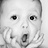

In [4]:
# Do visualization on one Image to see the image shape
rand_img = random.choice(train_img_path_list)
img_class = rand_img.parent.stem
img = Image.open(rand_img)

print(f"Path: {rand_img}\nImg class: {img_class}\nImg size: {img.size}")
img

In [5]:
class FERDataset(Dataset):
    def __init__(self, paths, classes, transform=None):
        self.paths = paths
        self.classes = classes
        self.transform = transform
        self.class_to_idx = {cls: i for i, cls in enumerate(sorted(set(classes)))}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path)
        class_idx = self.class_to_idx[self.classes[idx]]

        if self.transform:
            img = self.transform(img)

        return img, class_idx

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = FERDataset(train_paths, train_labels, train_transform)
val_dataset = FERDataset(val_paths, val_labels, base_transform)
test_dataset = FERDataset(test_path, test_labels, base_transform)
CLASS_NAMES = sorted(set(train_dataset.classes))

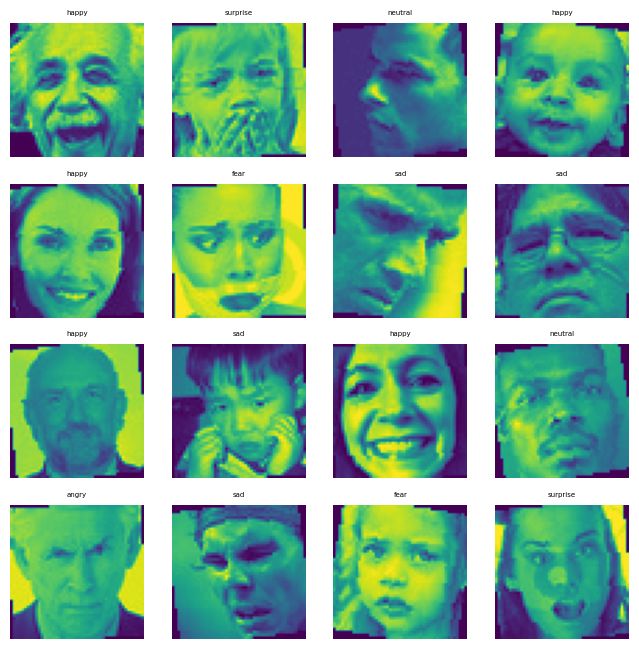

In [6]:
fig = plt.figure(figsize=(8,8))
rows, cols = 4,4
for i in range(1, rows * cols + 1):
    rand_idx = np.random.randint(0, len(train_dataset), size=1).item()
    img, label = train_dataset[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(CLASS_NAMES[label],fontdict={'fontsize':5})
    plt.axis(False);

In [7]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


train_dl = DataLoader(train_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)
val_dl = DataLoader(val_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    pin_memory=True,
                    num_workers=NUM_WORKERS)
test_dl = DataLoader(test_dataset, 
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      pin_memory=True,
                      num_workers=NUM_WORKERS)

In [8]:
class FERModel(nn.Module):
    def __init__(self, num_classes:int, hidden_units:int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(1, hidden_units*2, kernel_size=3, stride=1),
            
            nn.GELU(),
            nn.Conv2d(hidden_units*2, hidden_units*4, kernel_size=3, stride=1),
            nn.GELU(),
            nn.MaxPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units*4, hidden_units*6, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_units*6, hidden_units*8, kernel_size=3, padding=1),
            nn.GELU(),
            nn.MaxPool2d(2)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*8,hidden_units*16),
            nn.GELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_units*16, num_classes)
        )
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

model = FERModel(len(CLASS_NAMES), hidden_units=32).to(device)
model


FERModel(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=7, bias=True)
  )
)

In [9]:
def train_step(model, dataloader, loss_fn, optimizer, device, use_mixup=False, mixup_alpha=0.8):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        mixed_targets = None
        if use_mixup:
            X, mixed_targets = mix_up(X, y, mixup_alpha)
        
        optimizer.zero_grad()
        outputs = model(X)
        
        if use_mixup and mixed_targets is not None:
            loss = mixup_lossfn(outputs, mixed_targets, loss_fn)
        else:
            loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        y_preds = outputs.argmax(dim=1)
        train_acc += (y_preds == y).sum().item() / len(y_preds)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def val_step(model, dataloader, loss_fn, device):
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss += loss.item()
            y_preds = outputs.argmax(dim=1)
            val_acc += (y_preds == y).sum().item() / len(y_preds)

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc

# Train step
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device, scheduler=None, patience=5, save_path='best_model.pt'):

    results = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': []}

    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        
        train_loss, train_acc = train_step(model, train_dl, loss_fn, optimizer, device)
            
        val_loss, val_acc = val_step(model, val_dl, loss_fn, device)

        # scheduler step
        if scheduler:
            scheduler.step()

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

        print(
            f"Epoch {epoch+1:03}/{epochs:03} | "
            f"Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%"
        )
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'train_loss': train_loss,
                'train_acc': train_acc,
            },save_path)
            
            print(f"Epoch {epoch+1}: New best val loss: {val_loss:.4f}")
            print(f"Checkpoint saved to {save_path}")
        else:
            patience_counter += 1
            print(f"Epoch {epoch}: No Improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break


    print(f"Training completed. Best mode saved to {save_path}")
        
    return results


In [10]:
lr = 5e-4
epochs = 20

optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr/100)

results = train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device, scheduler)

Epoch 001/020 | Loss: 1.7937 | Acc: 24.82% | Val Loss: 1.7850 | Val Acc: 26.19%
Epoch 1: New best val loss: 1.7850
Checkpoint saved to best_model.pt
Epoch 002/020 | Loss: 1.7638 | Acc: 26.71% | Val Loss: 1.7371 | Val Acc: 28.32%
Epoch 2: New best val loss: 1.7371
Checkpoint saved to best_model.pt
Epoch 003/020 | Loss: 1.6226 | Acc: 34.60% | Val Loss: 1.5732 | Val Acc: 37.56%
Epoch 3: New best val loss: 1.5732
Checkpoint saved to best_model.pt
Epoch 004/020 | Loss: 1.4630 | Acc: 42.88% | Val Loss: 1.3859 | Val Acc: 46.45%
Epoch 4: New best val loss: 1.3859
Checkpoint saved to best_model.pt
Epoch 005/020 | Loss: 1.3504 | Acc: 47.62% | Val Loss: 1.3207 | Val Acc: 48.99%
Epoch 5: New best val loss: 1.3207
Checkpoint saved to best_model.pt
Epoch 006/020 | Loss: 1.2716 | Acc: 50.96% | Val Loss: 1.2495 | Val Acc: 52.34%
Epoch 6: New best val loss: 1.2495
Checkpoint saved to best_model.pt
Epoch 007/020 | Loss: 1.2116 | Acc: 53.50% | Val Loss: 1.1895 | Val Acc: 54.62%
Epoch 7: New best val loss

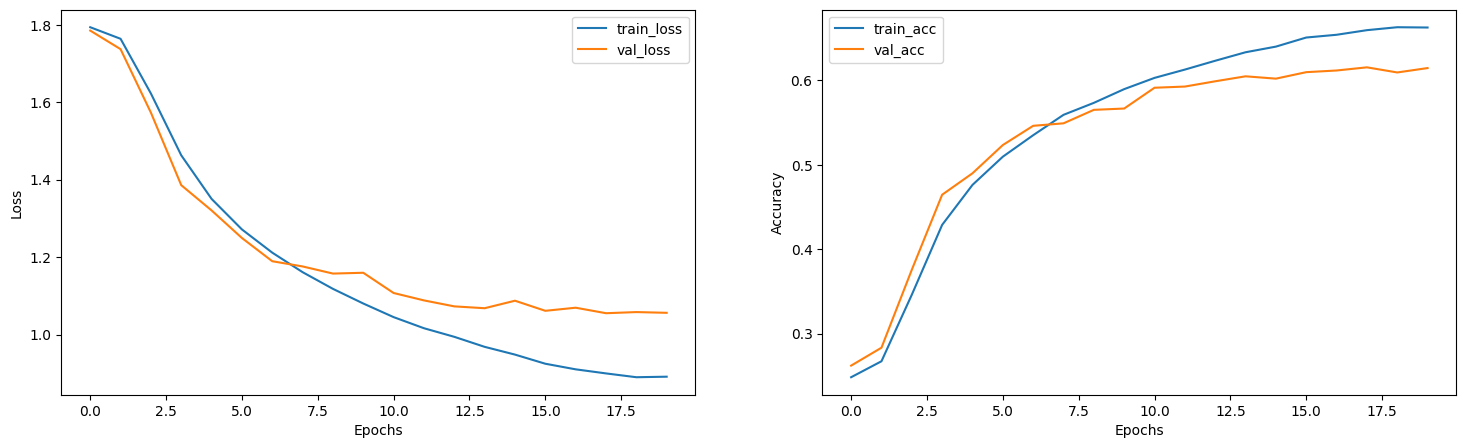

In [11]:
train_loss = results['train_loss']
train_acc = results['train_acc']
val_loss = results['val_loss']
val_acc = results['val_acc']

epochs_ = range(len(train_loss))
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.plot(epochs_, train_loss, label='train_loss')
plt.plot(epochs_, val_loss, label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_, train_acc, label='train_acc')
plt.plot(epochs_, val_acc, label='val_acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [12]:
# Evaluation on test dataset
def evaluation_step(model, test_dl, loss_fn, class_names, device):
    model.eval()
    test_loss, test_acc = 0, 0
    y_true, y_pred = [], []

    with torch.inference_mode():
        for X, y in test_dl:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            test_loss += loss.item()

            preds = outputs.argmax(dim=1)
            test_acc += (preds == y).sum().item() / len(preds)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = test_loss / len(test_dl)
    avg_acc = test_acc / len(test_dl)
    test_f1 = f1_score(y_true, y_pred, average='macro')
    
    tqdm.write(f"Test Loss: {avg_loss:.4f} | Test Acc: {avg_acc*100:.2f}% | Test F1: {test_f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show();

Loaded model from epoch 17
Checkpoint validation loss: 1.0552
Checkpoint validation accuracy: 61.55%
Test Loss: 1.0535 | Test Acc: 61.31% | Test F1: 0.5679


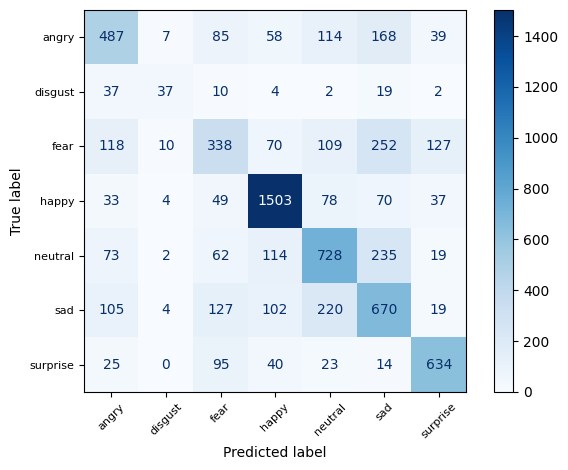

In [13]:
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Loaded model from epoch {checkpoint['epoch']}")
print(f"Checkpoint validation loss: {checkpoint['val_loss']:.4f}")
print(f"Checkpoint validation accuracy: {checkpoint['val_acc']*100:.2f}%")

evaluation_step(model, test_dl, loss_fn, class_names=CLASS_NAMES, device=device)